# STERA Plus

Swing or
Take
Expected
Runs
Added
Plus

## Libraries

In [74]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from boruta import BorutaPy

## Section 1 - Data Stuff

### Data Intake

MLB Statcast data from the 2020-2023 regular seasons. Starts in 2020 because that is the begining for the MLB using the Hawkeye tracking system.

https://technology.mlblogs.com/introducing-statcast-2020-hawk-eye-and-google-cloud-a5f5c20321b8

In [75]:
mlbpbp2020 = pd.read_csv('mlbpbp2020.csv')
mlbpbp2021 = pd.read_csv('mlbpbp2021.csv')
mlbpbp2022 = pd.read_csv('mlbpbp2022.csv')
mlbpbp2023 = pd.read_csv('mlbpbp2023.csv')

data = [mlbpbp2020, mlbpbp2021, mlbpbp2022, mlbpbp2023]

mlbPBP_raw = pd.concat(data)

In [76]:
mlbPBP = mlbPBP_raw.sort_values(['game_pk', 'at_bat_number', 'pitch_number']).copy()

In [77]:
mlbPBP = mlbPBP[(mlbPBP['balls'] < 4) & (mlbPBP['strikes'] < 3) & (mlbPBP['outs_when_up'] < 3)]

In [78]:
len(mlbPBP)

2399910

In [79]:
mlbPBP.head(10)

,game_date,game_year,game_pk,player_name,events,description,type,balls,strikes,outs_when_up,...,delta_run_exp,home_team,away_team,on_1b,on_2b,on_3b,inning,inning_topbot,bat_score,post_bat_score
0,2020-08-26,2020,630099,"Hampson, Garrett",NaN,called_strike,S,0,0,0,...,-0.042,AZ,COL,NaN,NaN,NaN,1,Top,0,0
1,2020-08-26,2020,630099,"Hampson, Garrett",NaN,ball,B,0,1,0,...,0.032,AZ,COL,NaN,NaN,NaN,1,Top,0,0
2,2020-08-26,2020,630099,"Hampson, Garrett",NaN,swinging_strike,S,1,1,0,...,-0.060,AZ,COL,NaN,NaN,NaN,1,Top,0,0
3,2020-08-26,2020,630099,"Hampson, Garrett",NaN,ball,B,1,2,0,...,0.035,AZ,COL,NaN,NaN,NaN,1,Top,0,0
4,2020-08-26,2020,630099,"Hampson, Garrett",NaN,ball,B,2,2,0,...,0.104,AZ,COL,NaN,NaN,NaN,1,Top,0,0
5,2020-08-26,2020,630099,"Hampson, Garrett",NaN,foul,S,3,2,0,...,0.000,AZ,COL,NaN,NaN,NaN,1,Top,0,0
6,2020-08-26,2020,630099,"Hampson, Garrett",walk,ball,B,3,2,0,...,0.333,AZ,COL,NaN,NaN,NaN,1,Top,0,0
57,2020-08-26,2020,630099,"Story, Trevor",NaN,ball,B,0,0,0,...,0.038,AZ,COL,641658.0,NaN,NaN,1,Top,0,0
58,2020-08-26,2020,630099,"Story, Trevor",NaN,ball,B,1,0,0,...,0.104,AZ,COL,641658.0,NaN,NaN,1,Top,0,0
59,2020-08-26,2020,630099,"Story, Trevor",NaN,ball,B,2,0,0,...,0.142,AZ,COL,NaN,641658.0,NaN,1,Top,0,0


### Feature Engineering

#### Labeling Outcomes

In [80]:
mlbPBP['description'].unique()

array(['called_strike', 'ball', 'swinging_strike', 'foul', 'blocked_ball',
       'hit_into_play', 'swinging_strike_blocked', 'hit_by_pitch',
       'foul_tip', 'foul_bunt', 'bunt_foul_tip', 'missed_bunt',
       'pitchout', 'foul_pitchout', 'unknown_strike'], dtype=object)

In [81]:
# Creating new column to label the outcome for each item in description
mlbPBP['pitch_outcome'] = np.where(
    mlbPBP['description'].isin(['ball', 'hit_by_pitch', 'called_strike', 'pitchout', 'blocked_ball']),
    'Take',
    np.where(
        mlbPBP['description'].isin(["swinging_strike", "swinging_strike_blocked", "foul_tip", "bunt_foul_tip", "missed_bunt"]) | 
        ((mlbPBP['strikes'] == 2) & (mlbPBP['description'] == "foul_bunt")),
        "Miss",
        np.where(
            mlbPBP['description'].isin(["foul", "foul_bunt"]),
            "Foul",
            np.where(
                mlbPBP['events'] == "single",
                "Single",
                np.where(
                    mlbPBP['events'] == "double",
                    "Double",
                    np.where(
                        mlbPBP['events'] == "triple",
                        "Triple",
                        np.where(
                            mlbPBP['events'] == "home_run",
                            "Homerun",
                            "Out")))))))

In [82]:
mlbPBP.head()

,game_date,game_year,game_pk,player_name,events,description,type,balls,strikes,outs_when_up,...,home_team,away_team,on_1b,on_2b,on_3b,inning,inning_topbot,bat_score,post_bat_score,pitch_outcome
0,2020-08-26,2020,630099,"Hampson, Garrett",NaN,called_strike,S,0,0,0,...,AZ,COL,NaN,NaN,NaN,1,Top,0,0,Take
1,2020-08-26,2020,630099,"Hampson, Garrett",NaN,ball,B,0,1,0,...,AZ,COL,NaN,NaN,NaN,1,Top,0,0,Take
2,2020-08-26,2020,630099,"Hampson, Garrett",NaN,swinging_strike,S,1,1,0,...,AZ,COL,NaN,NaN,NaN,1,Top,0,0,Miss
3,2020-08-26,2020,630099,"Hampson, Garrett",NaN,ball,B,1,2,0,...,AZ,COL,NaN,NaN,NaN,1,Top,0,0,Take
4,2020-08-26,2020,630099,"Hampson, Garrett",NaN,ball,B,2,2,0,...,AZ,COL,NaN,NaN,NaN,1,Top,0,0,Take


#### Encoding Base Runners

In [83]:
mlbPBP['on_1b'] = mlbPBP['on_1b'].notna().astype(int)
mlbPBP['on_2b'] = mlbPBP['on_2b'].notna().astype(int)
mlbPBP['on_3b'] = mlbPBP['on_3b'].notna().astype(int)

In [84]:
mlbPBP.head()

,game_date,game_year,game_pk,player_name,events,description,type,balls,strikes,outs_when_up,...,home_team,away_team,on_1b,on_2b,on_3b,inning,inning_topbot,bat_score,post_bat_score,pitch_outcome
0,2020-08-26,2020,630099,"Hampson, Garrett",NaN,called_strike,S,0,0,0,...,AZ,COL,0,0,0,1,Top,0,0,Take
1,2020-08-26,2020,630099,"Hampson, Garrett",NaN,ball,B,0,1,0,...,AZ,COL,0,0,0,1,Top,0,0,Take
2,2020-08-26,2020,630099,"Hampson, Garrett",NaN,swinging_strike,S,1,1,0,...,AZ,COL,0,0,0,1,Top,0,0,Miss
3,2020-08-26,2020,630099,"Hampson, Garrett",NaN,ball,B,1,2,0,...,AZ,COL,0,0,0,1,Top,0,0,Take
4,2020-08-26,2020,630099,"Hampson, Garrett",NaN,ball,B,2,2,0,...,AZ,COL,0,0,0,1,Top,0,0,Take


#### Adding Barrels

In [85]:
# Adding metric to asses batter quality of contact
conditions = []
for speed in range(98, 117):
    angle_min = 26 - (speed - 98)
    angle_max = 30 + (speed - 98)
    condition = (mlbPBP['launch_speed'] >= speed) & (mlbPBP['launch_angle'] >= angle_min) & (mlbPBP['launch_angle'] <= angle_max)
    conditions.append(condition)

# Combine all conditions using NumPy's logical_or
barrel_condition = np.logical_or.reduce(conditions)

# Assign the result to the 'Barrel' column
mlbPBP['Barrel'] = barrel_condition.astype(int)

#### Run Expectancy Table (RE288)

In [86]:
# Calculating the number of runs scored on the play
mlbPBP['runs_on_play'] = mlbPBP['post_bat_score'] - mlbPBP['bat_score']

In [87]:
# Adding some more metrics to asses the number of runs scored in the inning
grouped = mlbPBP.sort_values(['at_bat_number', 'pitch_number']).groupby(['inning', 'inning_topbot', 'game_pk'])

total_runs_per_inning = grouped['runs_on_play'].transform('sum').reset_index(drop=True)
cumulative_runs = grouped['runs_on_play'].cumsum().reset_index(drop=True)

mlbPBP['runs_rest_inning'] = total_runs_per_inning - cumulative_runs + mlbPBP['runs_on_play'].values

total_runs_inning = grouped['runs_on_play'].transform('sum').reset_index(drop=True)
mlbPBP['total_runs_inning'] = total_runs_inning

In [88]:
# Creating a column to add the runners that were on base before the pitch
mlbPBP['count_base_out_state'] = (
    mlbPBP['balls'].astype(str) + "-" + 
    mlbPBP['strikes'].astype(str) + ", " +
    mlbPBP['outs_when_up'].astype(str) + " outs, " +
    np.where(mlbPBP['on_1b'] == 1, "1b", "_") +
    np.where(mlbPBP['on_2b'] == 1, "2b", "_") +
    np.where(mlbPBP['on_3b'] == 1, "3b", "_")
)

In [89]:
# Shift relevant columns to get the data of the next pitch
next_pitch_data = mlbPBP[['inning', 'inning_topbot', 'balls', 'strikes', 'outs_when_up', 'on_1b', 'on_2b', 'on_3b']].shift(-1)

# Compare if the next pitch is in the same inning and half-inning
same_inning = (mlbPBP['inning'] == next_pitch_data['inning']) & (mlbPBP['inning_topbot'] == next_pitch_data['inning_topbot'])

next_pitch_data[~same_inning] = 0  # Resetting for new inning
next_pitch_data['outs_when_up'][~same_inning] = 3
next_pitch_data['on_1b'][~same_inning] = None
next_pitch_data['on_2b'][~same_inning] = None
next_pitch_data['on_3b'][~same_inning] = None

# Base state after the pitch
mlbPBP['post_count_base_out_state'] = (
    next_pitch_data['balls'].astype(int).astype(str) + "-" + 
    next_pitch_data['strikes'].astype(int).astype(str) + ", " +
    next_pitch_data['outs_when_up'].astype(int).astype(str) + " outs, " +
    np.where(next_pitch_data['on_1b'] == 1, "1b", "_") +
    np.where(next_pitch_data['on_2b'] == 1, "2b", "_") +
    np.where(next_pitch_data['on_3b'] == 1, "3b", "_")
)

mlbPBP[['count_base_out_state', 'post_count_base_out_state']].head()  # Displaying a sample of the result

,count_base_out_state,post_count_base_out_state
0,"0-0, 0 outs, ___","0-1, 0 outs, ___"
1,"0-1, 0 outs, ___","1-1, 0 outs, ___"
2,"1-1, 0 outs, ___","1-2, 0 outs, ___"
3,"1-2, 0 outs, ___","2-2, 0 outs, ___"
4,"2-2, 0 outs, ___","3-2, 0 outs, ___"


In [90]:
RE288 = mlbPBP.groupby(['count_base_out_state'])['runs_rest_inning'].agg(AvgRE='mean').sort_values('AvgRE', ascending=False).reset_index()

In [91]:
RE288.head(10)

,count_base_out_state,AvgRE
0,"3-0, 0 outs, 1b2b_",0.592875
1,"3-1, 0 outs, __3b",0.562092
2,"3-1, 0 outs, 1b2b3b",0.558011
3,"1-2, 0 outs, 1b2b3b",0.544471
4,"3-1, 0 outs, _2b3b",0.542453
5,"3-0, 0 outs, _2b_",0.539474
6,"0-2, 1 outs, __3b",0.539062
7,"3-0, 2 outs, 1b__",0.536070
8,"0-2, 1 outs, 1b2b3b",0.535135
9,"3-1, 1 outs, _2b3b",0.533482


#### Run Expectancy Logic

In [92]:
# Info for if a ball was thrown
ball_after = mlbPBP.copy()

ball_after['balls_after_ball'] = np.where(ball_after['balls'] < 3, ball_after['balls'] + 1, 0)
ball_after['strikes_after_ball'] = np.where(ball_after['balls'] < 3, ball_after['strikes'], 0)
ball_after['outs_when_up_after_ball'] = ball_after['outs_when_up']
ball_after['on_1b_after_ball'] = np.where((ball_after['balls'] == 3) & ball_after['on_1b'].isna(), 1, ball_after['on_1b'])
ball_after['on_2b_after_ball'] = np.where((ball_after['balls'] == 3) & ball_after['on_1b'].notna(), 1, ball_after['on_2b'])
ball_after['on_3b_after_ball'] = np.where((ball_after['balls'] == 3) & ball_after['on_1b'].notna() & ball_after['on_2b'].notna(), 1, ball_after['on_3b'])

ball_after['count_base_out_state_ball'] = (
    ball_after['balls_after_ball'].astype(int).astype(str) + "-" + 
    ball_after['strikes_after_ball'].astype(int).astype(str) + ", " +
    ball_after['outs_when_up_after_ball'].astype(int).astype(str) + " outs, " +
    np.where(ball_after['on_1b_after_ball'] == 1, "1b", "_") +
    np.where(ball_after['on_2b_after_ball'] == 1, "2b", "_") +
    np.where(ball_after['on_3b_after_ball'] == 1, "3b", "_")
)

ball_after = ball_after.merge(RE288, left_on='count_base_out_state_ball', right_on='count_base_out_state', how='left')
ball_after = ball_after.drop(['count_base_out_state_y'], axis=1)
ball_after = ball_after.rename(columns={"count_base_out_state_x": "count_base_out_state", "AvgRE": "AvgRE_Ball"})

ball_after.head(10)

,game_date,game_year,game_pk,player_name,events,description,type,balls,strikes,outs_when_up,...,count_base_out_state,post_count_base_out_state,balls_after_ball,strikes_after_ball,outs_when_up_after_ball,on_1b_after_ball,on_2b_after_ball,on_3b_after_ball,count_base_out_state_ball,AvgRE_Ball
0,2020-08-26,2020,630099,"Hampson, Garrett",NaN,called_strike,S,0,0,0,...,"0-0, 0 outs, ___","0-1, 0 outs, ___",1,0,0,0,0,0,"1-0, 0 outs, ___",0.471251
1,2020-08-26,2020,630099,"Hampson, Garrett",NaN,ball,B,0,1,0,...,"0-1, 0 outs, ___","1-1, 0 outs, ___",1,1,0,0,0,0,"1-1, 0 outs, ___",0.466788
2,2020-08-26,2020,630099,"Hampson, Garrett",NaN,swinging_strike,S,1,1,0,...,"1-1, 0 outs, ___","1-2, 0 outs, ___",2,1,0,0,0,0,"2-1, 0 outs, ___",0.473253
3,2020-08-26,2020,630099,"Hampson, Garrett",NaN,ball,B,1,2,0,...,"1-2, 0 outs, ___","2-2, 0 outs, ___",2,2,0,0,0,0,"2-2, 0 outs, ___",0.470955
4,2020-08-26,2020,630099,"Hampson, Garrett",NaN,ball,B,2,2,0,...,"2-2, 0 outs, ___","3-2, 0 outs, ___",3,2,0,0,0,0,"3-2, 0 outs, ___",0.476643
5,2020-08-26,2020,630099,"Hampson, Garrett",NaN,foul,S,3,2,0,...,"3-2, 0 outs, ___","3-2, 0 outs, ___",0,0,0,0,1,1,"0-0, 0 outs, _2b3b",0.479756
6,2020-08-26,2020,630099,"Hampson, Garrett",walk,ball,B,3,2,0,...,"3-2, 0 outs, ___","0-0, 0 outs, 1b__",0,0,0,0,1,1,"0-0, 0 outs, _2b3b",0.479756
7,2020-08-26,2020,630099,"Story, Trevor",NaN,ball,B,0,0,0,...,"0-0, 0 outs, 1b__","1-0, 0 outs, 1b__",1,0,0,1,0,0,"1-0, 0 outs, 1b__",0.473999
8,2020-08-26,2020,630099,"Story, Trevor",NaN,ball,B,1,0,0,...,"1-0, 0 outs, 1b__","2-0, 0 outs, _2b_",2,0,0,1,0,0,"2-0, 0 outs, 1b__",0.466759
9,2020-08-26,2020,630099,"Story, Trevor",NaN,ball,B,2,0,0,...,"2-0, 0 outs, _2b_","3-0, 0 outs, _2b_",3,0,0,0,1,0,"3-0, 0 outs, _2b_",0.539474


In [93]:
# Info for if a strike was thrown
strike_after = ball_after.copy()

strike_after['balls_after_strike'] = np.where(strike_after['strikes'] < 2, strike_after['balls'], 0)
strike_after['strikes_after_strike'] = np.where(strike_after['strikes'] < 2, strike_after['strikes'] + 1, 0)
strike_after['outs_when_up_after_strike'] = np.where(strike_after['strikes'] < 2, strike_after['outs_when_up'], strike_after['outs_when_up'] + 1)
strike_after['on_1b_after_strike'] = strike_after['on_1b']
strike_after['on_2b_after_strike'] = strike_after['on_2b']
strike_after['on_3b_after_strike'] = strike_after['on_3b']

strike_after['count_base_out_state_strike'] = (
    strike_after['balls_after_strike'].astype(int).astype(str) + "-" + 
    strike_after['strikes_after_strike'].astype(int).astype(str) + ", " +
    strike_after['outs_when_up_after_strike'].astype(int).astype(str) + " outs, " +
    np.where(strike_after['on_1b_after_strike'] == 1, "1b", "_") +
    np.where(strike_after['on_2b_after_strike'] == 1, "2b", "_") +
    np.where(strike_after['on_3b_after_strike'] == 1, "3b", "_")
)

strike_after = strike_after.merge(RE288, how='left', left_on='count_base_out_state_strike', right_on='count_base_out_state')
strike_after = strike_after.drop(['count_base_out_state_y'], axis=1)
strike_after = strike_after.rename(columns={"count_base_out_state_x": "count_base_out_state", "AvgRE": "AvgRE_Strike"})

strike_after.loc[strike_after['outs_when_up_after_strike'] == 3, 'AvgRE_Strike'] = 0

strike_after.head(10)

,game_date,game_year,game_pk,player_name,events,description,type,balls,strikes,outs_when_up,...,count_base_out_state_ball,AvgRE_Ball,balls_after_strike,strikes_after_strike,outs_when_up_after_strike,on_1b_after_strike,on_2b_after_strike,on_3b_after_strike,count_base_out_state_strike,AvgRE_Strike
0,2020-08-26,2020,630099,"Hampson, Garrett",NaN,called_strike,S,0,0,0,...,"1-0, 0 outs, ___",0.471251,0,1,0,0,0,0,"0-1, 0 outs, ___",0.458254
1,2020-08-26,2020,630099,"Hampson, Garrett",NaN,ball,B,0,1,0,...,"1-1, 0 outs, ___",0.466788,0,2,0,0,0,0,"0-2, 0 outs, ___",0.466992
2,2020-08-26,2020,630099,"Hampson, Garrett",NaN,swinging_strike,S,1,1,0,...,"2-1, 0 outs, ___",0.473253,1,2,0,0,0,0,"1-2, 0 outs, ___",0.464521
3,2020-08-26,2020,630099,"Hampson, Garrett",NaN,ball,B,1,2,0,...,"2-2, 0 outs, ___",0.470955,0,0,1,0,0,0,"0-0, 1 outs, ___",0.466971
4,2020-08-26,2020,630099,"Hampson, Garrett",NaN,ball,B,2,2,0,...,"3-2, 0 outs, ___",0.476643,0,0,1,0,0,0,"0-0, 1 outs, ___",0.466971
5,2020-08-26,2020,630099,"Hampson, Garrett",NaN,foul,S,3,2,0,...,"0-0, 0 outs, _2b3b",0.479756,0,0,1,0,0,0,"0-0, 1 outs, ___",0.466971
6,2020-08-26,2020,630099,"Hampson, Garrett",walk,ball,B,3,2,0,...,"0-0, 0 outs, _2b3b",0.479756,0,0,1,0,0,0,"0-0, 1 outs, ___",0.466971
7,2020-08-26,2020,630099,"Story, Trevor",NaN,ball,B,0,0,0,...,"1-0, 0 outs, 1b__",0.473999,0,1,0,1,0,0,"0-1, 0 outs, 1b__",0.456828
8,2020-08-26,2020,630099,"Story, Trevor",NaN,ball,B,1,0,0,...,"2-0, 0 outs, 1b__",0.466759,1,1,0,1,0,0,"1-1, 0 outs, 1b__",0.466579
9,2020-08-26,2020,630099,"Story, Trevor",NaN,ball,B,2,0,0,...,"3-0, 0 outs, _2b_",0.539474,2,1,0,0,1,0,"2-1, 0 outs, _2b_",0.444444


## Section 2 - Modeling Stuff

#### Functions

In [94]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from joblib import dump, load

In [95]:
def modelEval(testDF, predsDF):
    print(f'AUC: {metrics.roc_auc_score(testDF, predsDF)}')
    print(f'MSE: {metrics.mean_squared_error(testDF, predsDF)}')
    print(f'r2: {metrics.r2_score(testDF, predsDF)}')

def linModelEval(testDF, predsDF):
    print(f'MSE: {metrics.mean_squared_error(testDF, predsDF)}')
    print(f'r2: {metrics.r2_score(testDF, predsDF)}')

def predictionEvaluation(data):
    col = data[0]
    print(f'Mean: {col.mean()}')
    print(f'Median: {col.median()}')
    print(f'SD: {col.std()}')
    print(f'Min: {col.min()}')
    print(f'Max: {col.max()}')
    
def stuffEvaluation(data):
    col = data[0]
    print(f'Mean: {col.mean().round(2)}')
    print(f'Median: {col.median().round(2)}')
    print(f'SD: {col.std().round(2)}')
    print(f'Min: {col.min().round(2)}')
    print(f'Max: {col.max().round(2)}')

### Strike Prediction Model

Model. 

Heatmap. 

Logic for run expectancy ball and strike data frames, create run expectancy states for next possible outcomes (ball/strike) based on current situations. Ref EAGLE code for more infor on it.

Create variable with the run expectancy total for taking a pitch.

In [96]:
takenPitches = mlbPBP[(mlbPBP['description'].isin(['ball', 'called_strike'])) & mlbPBP['plate_x'].notna() & mlbPBP['plate_z'].notna()].copy()

takenPitches['strike'] = np.where(takenPitches['description'] == 'called_strike', 1, 0)

takenPitches.head(10)

,game_date,game_year,game_pk,player_name,events,description,type,balls,strikes,outs_when_up,...,bat_score,post_bat_score,pitch_outcome,Barrel,runs_on_play,runs_rest_inning,total_runs_inning,count_base_out_state,post_count_base_out_state,strike
0,2020-08-26,2020,630099,"Hampson, Garrett",NaN,called_strike,S,0,0,0,...,0,0,Take,0,0,2,2,"0-0, 0 outs, ___","0-1, 0 outs, ___",1
1,2020-08-26,2020,630099,"Hampson, Garrett",NaN,ball,B,0,1,0,...,0,0,Take,0,0,0,0,"0-1, 0 outs, ___","1-1, 0 outs, ___",0
3,2020-08-26,2020,630099,"Hampson, Garrett",NaN,ball,B,1,2,0,...,0,0,Take,0,0,1,1,"1-2, 0 outs, ___","2-2, 0 outs, ___",0
4,2020-08-26,2020,630099,"Hampson, Garrett",NaN,ball,B,2,2,0,...,0,0,Take,0,0,0,0,"2-2, 0 outs, ___","3-2, 0 outs, ___",0
6,2020-08-26,2020,630099,"Hampson, Garrett",walk,ball,B,3,2,0,...,0,0,Take,0,0,0,0,"3-2, 0 outs, ___","0-0, 0 outs, 1b__",0
57,2020-08-26,2020,630099,"Story, Trevor",NaN,ball,B,0,0,0,...,0,0,Take,0,0,2,2,"0-0, 0 outs, 1b__","1-0, 0 outs, 1b__",0
58,2020-08-26,2020,630099,"Story, Trevor",NaN,ball,B,1,0,0,...,0,0,Take,0,0,5,5,"1-0, 0 outs, 1b__","2-0, 0 outs, _2b_",0
59,2020-08-26,2020,630099,"Story, Trevor",NaN,ball,B,2,0,0,...,0,0,Take,0,0,0,0,"2-0, 0 outs, _2b_","3-0, 0 outs, _2b_",0
60,2020-08-26,2020,630099,"Story, Trevor",walk,ball,B,3,0,0,...,0,0,Take,0,0,2,2,"3-0, 0 outs, _2b_","0-0, 0 outs, 1b2b_",0
108,2020-08-26,2020,630099,"Arenado, Nolan",NaN,called_strike,S,0,0,0,...,0,0,Take,0,0,0,0,"0-0, 0 outs, 1b2b_","0-1, 0 outs, 1b2b_",1


In [97]:
np.random.seed(2121)

takenPitches_train = takenPitches[['plate_x', 'plate_z', 'sz_top', 'sz_bot', 'strike']]
takenPitches_train_noK = takenPitches_train.iloc[:, :-1]
takenPitches_label = takenPitches['strike']

X_train, X_test, y_train, y_test = train_test_split(takenPitches_train_noK, takenPitches_label, test_size = 0.1)

dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)

Boruta takes a LONG time to run, it found all of our features to be useful.

In [98]:
#xgbc = xgb.XGBClassifier()

#boruta_selector = BorutaPy(xgbc, n_estimators='auto', random_state=42)

#boruta_selector.fit(X_train.values, y_train)

#boruta_selector = load('boruta_model.joblib')

#feature_ranks = boruta_selector.ranking_

#feature_importance = boruta_selector.support_

#feature_df = pd.DataFrame({
#    'Feature': X_train.columns,
#    'Rank': feature_ranks,
#    'Important': feature_importance
#})

#feature_df

#X_important_train = boruta_selector.transform(X_train.values)
#X_important_train_df = pd.DataFrame(X_important_train, columns=X_train.columns[boruta_selector.support_])
#X_important_train_df

#dump(boruta_selector, 'boruta_model.joblib')

#boruta_selector = load('boruta_model.joblib')

#plt.figure(figsize=(12, 6))
#sns.barplot(x='Feature', y='Rank', data=feature_df.sort_values(by='Rank', ascending=True))
#plt.xticks(rotation=90)
#plt.title('Boruta Feature Rankings')

In [99]:
params = {"objective": "binary:logistic", 
          "eval_metric":"auc", 
          "eta": 0.3, 
          "learning_rate":0.2
          }

strikeProbModel = xgb.train({'learning_rate':0.2, 'max_depth':10},
                    num_boost_round = 50, 
                    dtrain=dtrain
                    )

In [100]:
feature_importance = strikeProbModel.get_score(importance_type='weight')

feature_importance_df = pd.DataFrame(feature_importance.items(), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)
feature_importance_df.head()

,Feature,Importance
0,plate_x,11674.0
1,plate_z,9302.0
2,sz_top,7184.0
3,sz_bot,6232.0


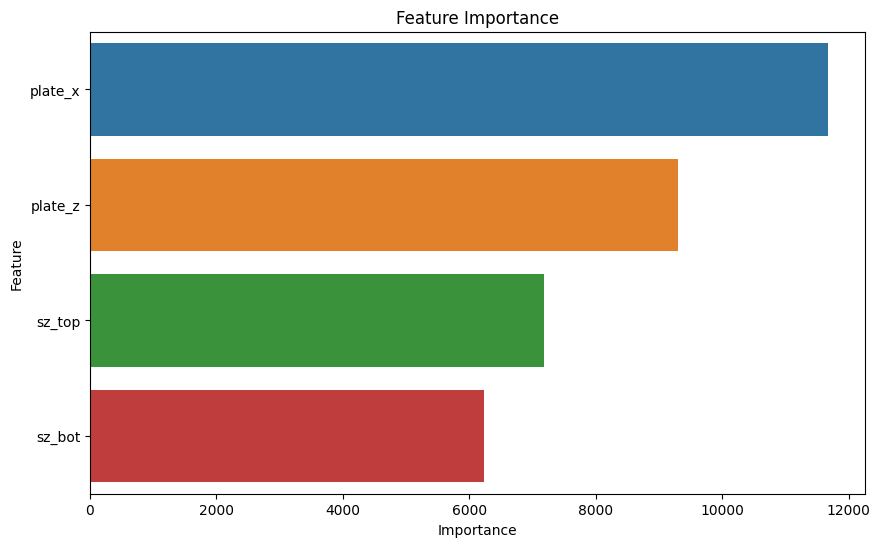

In [101]:
sorted_feature_importance = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    y='Feature',
    x='Importance',
    data=sorted_feature_importance
)
plt.title('Feature Importance')
plt.show()

In [102]:
y_preds = strikeProbModel.predict(dtest)
y_preds = pd.DataFrame(y_preds)

predictionEvaluation(y_preds)

Mean: 0.3311229348182678
Median: 0.02776273898780346
SD: 0.41637492179870605
Min: -0.22781848907470703
Max: 1.1112136840820312


In [103]:
modelEval(y_test,  y_preds)

AUC: 0.9819894229947332
MSE: 0.04920297387442438
r2: 0.7778532603124527


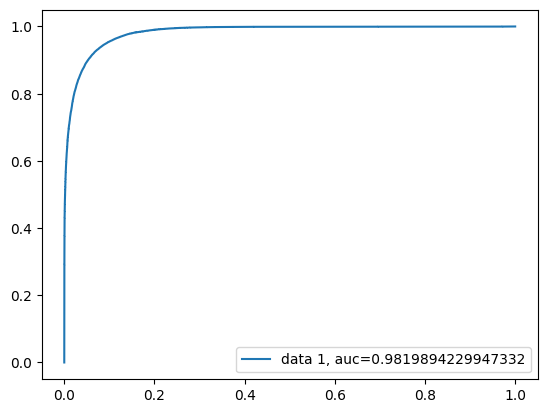

In [104]:
fpr, tpr, threshold = metrics.roc_curve(y_test,  y_preds)
auc = metrics.roc_auc_score(y_test, y_preds)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [105]:
x = np.linspace(-1.5, 1.5, 100)
y = np.linspace(0.5, 5, 100)
X, Y = np.meshgrid(x, y)

sz_top_mean = takenPitches_train['sz_top'].mean(skipna=True)
sz_bot_mean = takenPitches_train['sz_bot'].mean(skipna=True)

preds = pd.DataFrame({'plate_x': X.ravel(), 'plate_z': Y.ravel()})
preds['sz_top'] = sz_top_mean
preds['sz_bot'] = sz_bot_mean

zone_preds = xgb.DMatrix(preds)
strikezone_preds = strikeProbModel.predict(zone_preds)
preds['strikezone_preds'] = strikezone_preds

topKzone = sz_top_mean
botKzone = sz_bot_mean
inKzone, outKzone = -0.84, 0.84
kZone = np.array([[inKzone, botKzone], [inKzone, topKzone], [outKzone, topKzone], [outKzone, botKzone], [inKzone, botKzone]])

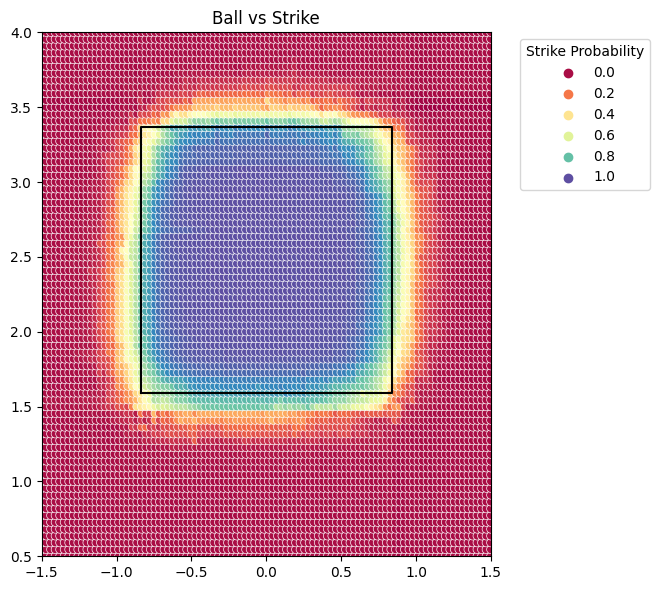

In [106]:
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x='plate_x', y='plate_z', hue='strikezone_preds', data=preds, palette='Spectral')
ax.plot(kZone[:, 0], kZone[:, 1], color='black', lw=1.5)

# Set axis limits and aspect
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(0.5, 4)
ax.set_aspect('equal', 'box')
plt.legend(title='Strike Probability', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Ball vs Strike')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

#### Calculate Strike Probability

The stuff here should probably go in the feature engineering section

In [107]:
strike_after.head(10)

,game_date,game_year,game_pk,player_name,events,description,type,balls,strikes,outs_when_up,...,count_base_out_state_ball,AvgRE_Ball,balls_after_strike,strikes_after_strike,outs_when_up_after_strike,on_1b_after_strike,on_2b_after_strike,on_3b_after_strike,count_base_out_state_strike,AvgRE_Strike
0,2020-08-26,2020,630099,"Hampson, Garrett",NaN,called_strike,S,0,0,0,...,"1-0, 0 outs, ___",0.471251,0,1,0,0,0,0,"0-1, 0 outs, ___",0.458254
1,2020-08-26,2020,630099,"Hampson, Garrett",NaN,ball,B,0,1,0,...,"1-1, 0 outs, ___",0.466788,0,2,0,0,0,0,"0-2, 0 outs, ___",0.466992
2,2020-08-26,2020,630099,"Hampson, Garrett",NaN,swinging_strike,S,1,1,0,...,"2-1, 0 outs, ___",0.473253,1,2,0,0,0,0,"1-2, 0 outs, ___",0.464521
3,2020-08-26,2020,630099,"Hampson, Garrett",NaN,ball,B,1,2,0,...,"2-2, 0 outs, ___",0.470955,0,0,1,0,0,0,"0-0, 1 outs, ___",0.466971
4,2020-08-26,2020,630099,"Hampson, Garrett",NaN,ball,B,2,2,0,...,"3-2, 0 outs, ___",0.476643,0,0,1,0,0,0,"0-0, 1 outs, ___",0.466971
5,2020-08-26,2020,630099,"Hampson, Garrett",NaN,foul,S,3,2,0,...,"0-0, 0 outs, _2b3b",0.479756,0,0,1,0,0,0,"0-0, 1 outs, ___",0.466971
6,2020-08-26,2020,630099,"Hampson, Garrett",walk,ball,B,3,2,0,...,"0-0, 0 outs, _2b3b",0.479756,0,0,1,0,0,0,"0-0, 1 outs, ___",0.466971
7,2020-08-26,2020,630099,"Story, Trevor",NaN,ball,B,0,0,0,...,"1-0, 0 outs, 1b__",0.473999,0,1,0,1,0,0,"0-1, 0 outs, 1b__",0.456828
8,2020-08-26,2020,630099,"Story, Trevor",NaN,ball,B,1,0,0,...,"2-0, 0 outs, 1b__",0.466759,1,1,0,1,0,0,"1-1, 0 outs, 1b__",0.466579
9,2020-08-26,2020,630099,"Story, Trevor",NaN,ball,B,2,0,0,...,"3-0, 0 outs, _2b_",0.539474,2,1,0,0,1,0,"2-1, 0 outs, _2b_",0.444444


In [108]:
taken_pitches = strike_after[strike_after['pitch_outcome'] != 'Take'].copy()
taken_pitches = taken_pitches.dropna()

takes_model = taken_pitches[['plate_x', 'plate_z', 'sz_top', 'sz_bot']]

dtrain_takes = xgb.DMatrix(takes_model, enable_categorical=True)

y_preds_takes = strikeProbModel.predict(dtrain_takes)
y_preds_takes = pd.DataFrame(y_preds_takes)

y_preds_takes.loc[y_preds_takes[0] < 0, 0] = 0
y_preds_takes.loc[y_preds_takes[0] > 1, 0] = 1

predictionEvaluation(y_preds_takes)

take_outcomes = pd.concat([taken_pitches, y_preds_takes], axis=1)
take_outcomes = take_outcomes.rename(columns={0: 'strike_prob'})

take_outcomes.head()

Mean: 0.794542133808136
Median: 0.9815458655357361
SD: 0.3286258280277252
Min: 0.0
Max: 1.0


,game_date,game_year,game_pk,player_name,events,description,type,balls,strikes,outs_when_up,...,AvgRE_Ball,balls_after_strike,strikes_after_strike,outs_when_up_after_strike,on_1b_after_strike,on_2b_after_strike,on_3b_after_strike,count_base_out_state_strike,AvgRE_Strike,strike_prob
14,2020-08-26,2020.0,630099.0,"Arenado, Nolan",double,hit_into_play,X,1.0,2.0,0.0,...,0.466451,0.0,0.0,1.0,1.0,1.0,0.0,"0-0, 1 outs, 1b2b_",0.454393,1.000000
17,2020-08-26,2020.0,630099.0,"Blackmon, Charlie",field_out,hit_into_play,X,0.0,2.0,0.0,...,0.438010,0.0,0.0,1.0,0.0,1.0,0.0,"0-0, 1 outs, _2b_",0.469316,0.811948
25,2020-08-26,2020.0,630099.0,"DÃ­az, Elias",field_out,hit_into_play,X,2.0,2.0,2.0,...,0.473216,0.0,0.0,3.0,0.0,1.0,0.0,"0-0, 3 outs, _2b_",0.000000,0.997368
35,2020-08-26,2020.0,630099.0,"Marte, Ketel",field_out,hit_into_play,X,1.0,2.0,1.0,...,0.470914,0.0,0.0,2.0,0.0,0.0,0.0,"0-0, 2 outs, ___",0.469149,0.990926
54,2020-08-26,2020.0,630099.0,"Peralta, David",field_out,hit_into_play,X,0.0,1.0,0.0,...,0.466788,0.0,2.0,0.0,0.0,0.0,0.0,"0-2, 0 outs, ___",0.466992,0.999694


In [109]:
take_outcomes['AvgRE_Take'] = (take_outcomes['AvgRE_Ball'] * (1 - take_outcomes['strike_prob'])) - (take_outcomes['AvgRE_Strike'] * take_outcomes['strike_prob'])

take_outcomes = take_outcomes[['plate_x', 'plate_z', 'balls', 'strikes', 'on_1b', 'on_2b', 'on_3b', 'strike_prob', 'AvgRE_Strike', 'AvgRE_Ball', 'AvgRE_Take']]

take_outcomes.head()

,plate_x,plate_z,balls,strikes,on_1b,on_2b,on_3b,strike_prob,AvgRE_Strike,AvgRE_Ball,AvgRE_Take
14,-0.15,1.97,1.0,2.0,1.0,1.0,0.0,1.000000,0.454393,0.466451,-0.454393
17,-0.42,3.15,0.0,2.0,0.0,1.0,0.0,0.811948,0.469316,0.438010,-0.298692
25,0.31,1.90,2.0,2.0,0.0,1.0,0.0,0.997368,0.000000,0.473216,0.001245
35,0.06,3.69,1.0,2.0,0.0,0.0,0.0,0.990926,0.469149,0.470914,-0.460619
54,0.36,3.23,0.0,1.0,0.0,0.0,0.0,0.999694,0.466992,0.466788,-0.466706


### Outcome Probability Model

Use statcast data for creating metrics for players with the swings dataset to be used in the classification model. 

Build classification model using xgboost to determine outcome probabilities of Miss, Foul, Out, Single, Double, Triple, and Homerun.

In [110]:
swings = mlbPBP.copy()

swings = swings[swings['pitch_outcome'] != 'Take']
labelencoder = LabelEncoder()
label_mapping = {
    'Miss': 0,
    'Foul': 1,
    'Out': 2,
    'Single': 3,
    'Double': 4,
    'Triple': 5,
    'Homerun': 6
}

swings['pitch_outcome'] = swings['pitch_outcome'].map(label_mapping)
swings['stand'] = labelencoder.fit_transform(swings['stand'])
swings['p_throws'] = labelencoder.fit_transform(swings['p_throws'])
swings['pitch_type'] = labelencoder.fit_transform(swings['pitch_type'])

swings.head(10)

,game_date,game_year,game_pk,player_name,events,description,type,balls,strikes,outs_when_up,...,inning_topbot,bat_score,post_bat_score,pitch_outcome,Barrel,runs_on_play,runs_rest_inning,total_runs_inning,count_base_out_state,post_count_base_out_state
2,2020-08-26,2020,630099,"Hampson, Garrett",NaN,swinging_strike,S,1,1,0,...,Top,0,0,0,0,0,2,2,"1-1, 0 outs, ___","1-2, 0 outs, ___"
5,2020-08-26,2020,630099,"Hampson, Garrett",NaN,foul,S,3,2,0,...,Top,0,0,1,0,0,0,0,"3-2, 0 outs, ___","3-2, 0 outs, ___"
109,2020-08-26,2020,630099,"Arenado, Nolan",NaN,swinging_strike,S,0,1,0,...,Top,0,0,0,0,0,1,1,"0-1, 0 outs, 1b2b_","0-2, 0 outs, 1b2b_"
111,2020-08-26,2020,630099,"Arenado, Nolan",double,hit_into_play,X,1,2,0,...,Top,0,2,4,0,2,0,0,"1-2, 0 outs, 1b2b_","0-0, 0 outs, _2b_"
144,2020-08-26,2020,630099,"Blackmon, Charlie",NaN,foul,S,0,0,0,...,Top,2,2,1,0,0,0,0,"0-0, 0 outs, _2b_","0-1, 0 outs, _2b_"
145,2020-08-26,2020,630099,"Blackmon, Charlie",NaN,foul,S,0,1,0,...,Top,2,2,1,0,0,4,4,"0-1, 0 outs, _2b_","0-2, 0 outs, _2b_"
146,2020-08-26,2020,630099,"Blackmon, Charlie",field_out,hit_into_play,X,0,2,0,...,Top,2,2,2,0,0,1,1,"0-2, 0 outs, _2b_","0-0, 1 outs, _2b_"
237,2020-08-26,2020,630099,"DÃ­az, Elias",NaN,swinging_strike_blocked,S,0,0,2,...,Top,2,2,0,0,0,2,2,"0-0, 2 outs, _2b_","0-1, 2 outs, _2b_"
238,2020-08-26,2020,630099,"DÃ­az, Elias",NaN,foul,S,0,1,2,...,Top,2,2,1,0,0,0,0,"0-1, 2 outs, _2b_","0-2, 2 outs, _2b_"
241,2020-08-26,2020,630099,"DÃ­az, Elias",field_out,hit_into_play,X,2,2,2,...,Top,2,2,2,0,0,0,0,"2-2, 2 outs, _2b_","0-0, 3 outs, ___"


In [111]:
np.random.seed(2121)

swings = swings[['balls', 'strikes', 'outs_when_up', 'stand', 'p_throws', 'pitch_type', 'plate_x', 'plate_z', 'pfx_x', 'pfx_z', 'release_speed', 'release_spin_rate', 'spin_axis', 'release_extension', 'release_pos_y', 'release_pos_x', 'release_pos_z', 'pitch_outcome']]
swings = swings.dropna()

swings_train = swings.iloc[:,:-1]
swings_label = swings['pitch_outcome']

X_train, X_test, y_train, y_test = train_test_split(swings_train, swings_label, test_size = 0.1)

Boruta takes a LONG time to run, the results of it showed only one feature, 'release_extension', was not useful. So we remove it.

In [112]:
#xgbc = xgb.XGBClassifier()

#boruta_selector = BorutaPy(xgbc, n_estimators='auto', random_state=42)

#boruta_selector.fit(X_train.values, y_train)

#boruta_selector = load('boruta_model.joblib')

#feature_ranks = boruta_selector.ranking_

#feature_importance = boruta_selector.support_

#feature_df = pd.DataFrame({
#    'Feature': X_train.columns,
#    'Rank': feature_ranks,
#    'Important': feature_importance
#})

#feature_df

#X_important_train = boruta_selector.transform(X_train.values)
#X_important_train_df = pd.DataFrame(X_important_train, columns=X_train.columns[boruta_selector.support_])
#X_important_train_df

#dump(boruta_selector, 'boruta_model.joblib')

#boruta_selector = load('boruta_model.joblib')

#plt.figure(figsize=(12, 6))
#sns.barplot(x='Feature', y='Rank', data=feature_df.sort_values(by='Rank', ascending=True))
#plt.xticks(rotation=90)
#plt.title('Boruta Feature Rankings')

In [113]:
X_train = X_train.drop('release_extension', axis=1)
X_test = X_test.drop('release_extension', axis=1)

dtrain_out = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_out = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [114]:
num_classes = np.unique(y_train).shape[0]

params = {
    "objective": "multi:softprob",
    "eval_metric": "merror",
    "eta": 0.3,
    "learning_rate": 0.2,
    "num_class": num_classes, 
    "max_depth": 10 
}

outcomeProbModel = xgb.train(params,
                             dtrain=dtrain_out,
                             num_boost_round=50)

In [115]:
feature_importance = outcomeProbModel.get_score(importance_type='weight')

feature_importance_df = pd.DataFrame(feature_importance.items(), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)
feature_importance_df.head()

,Feature,Importance
6,plate_x,16619.0
11,release_spin_rate,15301.0
10,release_speed,15127.0
7,plate_z,14783.0
9,pfx_z,14614.0


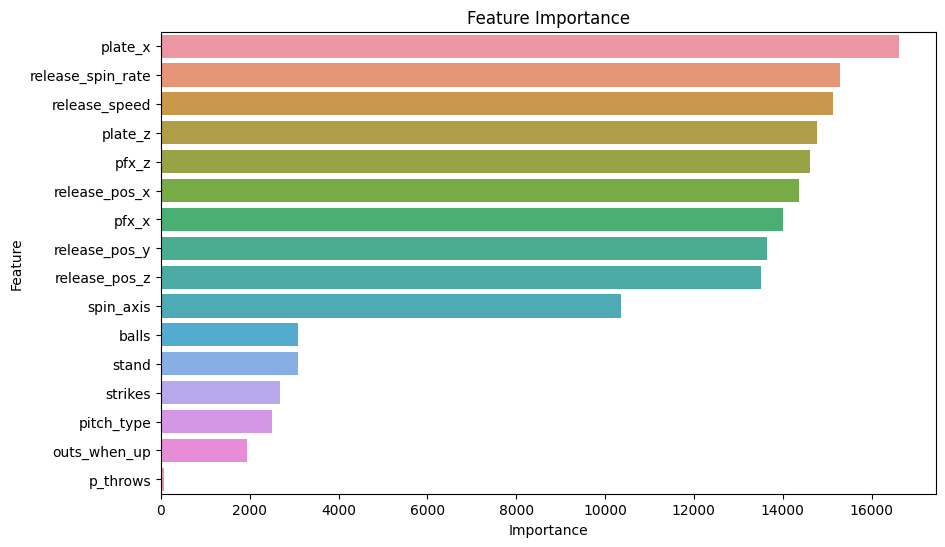

In [116]:
sorted_feature_importance = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    y='Feature',
    x='Importance',
    data=sorted_feature_importance
)
plt.title('Feature Importance')
plt.show()

In [117]:
y_preds = outcomeProbModel.predict(dtest_out)
y_preds = pd.DataFrame(y_preds)
y_preds.columns = label_mapping

reverse_mapping = {
    0: 'Miss',
    1: 'Foul',
    2: 'Out',
    3: 'Single',
    4: 'Double',
    5: 'Triple',
    6: 'Homerun'
}

y_test_preds = pd.DataFrame(y_test).reset_index()
y_test_preds['pitch_outcome'] = y_test_preds['pitch_outcome'].map(reverse_mapping)
y_preds['true_outcome'] = y_test_preds['pitch_outcome']

result_df = y_preds.groupby('true_outcome').mean().transpose()

result_df[['Miss', 'Foul', 'Out', 'Single', 'Double', 'Triple', 'Homerun']].head(10)

true_outcome,Miss,Foul,Out,Single,Double,Triple,Homerun
Miss,0.411231,0.220744,0.192886,0.184171,0.172134,0.179484,0.162902
Foul,0.322275,0.405737,0.384841,0.383174,0.395294,0.395661,0.407556
Out,0.181931,0.250861,0.284172,0.289718,0.286041,0.280672,0.282210
Single,0.054667,0.076363,0.087786,0.092554,0.088580,0.086696,0.084425
Double,0.016477,0.024928,0.027613,0.027983,0.031214,0.030208,0.031942
Triple,0.002015,0.002733,0.002928,0.002977,0.003148,0.003550,0.003314
Homerun,0.011404,0.018634,0.019774,0.019423,0.023588,0.023729,0.027651


### Run Expectancy Prediction Model

In [118]:
runExpectancy = strike_after.copy()

runExpectancy = runExpectancy[['balls', 'strikes', 'outs_when_up', 'on_1b', 'on_2b', 'on_3b', 'plate_x', 'plate_z', 'pfx_x', 'pfx_z', 'release_speed', 'release_spin_rate', 'spin_axis', 'release_extension', 'release_pos_y', 'release_pos_x', 'release_pos_z', 'delta_run_exp']]
runExpectancy = runExpectancy.dropna()

runExpectancy_train = runExpectancy.iloc[:, :-1]
runExpectancy_label = runExpectancy['delta_run_exp']

X_train, X_test, y_train, y_test = train_test_split(runExpectancy_train, runExpectancy_label, test_size = 0.1)

In [119]:
runExpectancy.head()

,balls,strikes,outs_when_up,on_1b,on_2b,on_3b,plate_x,plate_z,pfx_x,pfx_z,release_speed,release_spin_rate,spin_axis,release_extension,release_pos_y,release_pos_x,release_pos_z,delta_run_exp
0,0,0,0,0,0,0,-0.23,2.17,0.68,1.55,95.2,2555.0,144.0,6.6,53.86,2.19,6.19,-0.042
1,0,1,0,0,0,0,-1.41,2.68,0.86,1.51,94.9,2540.0,148.0,6.5,54.00,1.96,6.32,0.032
2,1,1,0,0,0,0,-0.85,0.68,0.43,0.44,87.9,2413.0,139.0,6.6,53.94,2.25,6.10,-0.060
3,1,2,0,0,0,0,-0.92,-0.54,0.08,0.45,88.2,2356.0,132.0,6.3,54.18,2.44,5.96,0.035
4,2,2,0,0,0,0,-1.35,2.03,0.74,1.51,95.8,2599.0,149.0,6.6,53.91,1.93,6.23,0.104


Boruta takes a LONG time to run, the results of it showed only one variable, 'release_extension', was not useful.

In [120]:
#xgbc = xgb.XGBClassifier()

#boruta_selector = BorutaPy(xgbc, n_estimators='auto', random_state=42)

#boruta_selector.fit(X_train.values, y_train)

#boruta_selector = load('boruta_model.joblib')

#feature_ranks = boruta_selector.ranking_

#feature_importance = boruta_selector.support_

#feature_df = pd.DataFrame({
#    'Feature': X_train.columns,
#    'Rank': feature_ranks,
#    'Important': feature_importance
#})

#feature_df

#X_important_train = boruta_selector.transform(X_train.values)
#X_important_train_df = pd.DataFrame(X_important_train, columns=X_train.columns[boruta_selector.support_])
#X_important_train_df

#dump(boruta_selector, 'boruta_model.joblib')

#boruta_selector = load('boruta_model.joblib')

#plt.figure(figsize=(12, 6))
#sns.barplot(x='Feature', y='Rank', data=feature_df.sort_values(by='Rank', ascending=True))
#plt.xticks(rotation=90)
#plt.title('Boruta Feature Rankings')

In [121]:
params = {"objective": "reg:linear", 
          "eval_metric":"auc", 
          "eta": 0.3, 
          "learning_rate":0.2
          }

from xgboost import XGBRegressor

runExpectancyModel = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.2,
    max_depth=10,
    n_estimators=50
)

runExpectancyModel.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [122]:
feature_importance = runExpectancyModel.feature_importances_

#feature_importance_df = pd.DataFrame(feature_importance.items(), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)
feature_importance_df.head()

,Feature,Importance
6,plate_x,16619.0
11,release_spin_rate,15301.0
10,release_speed,15127.0
7,plate_z,14783.0
9,pfx_z,14614.0


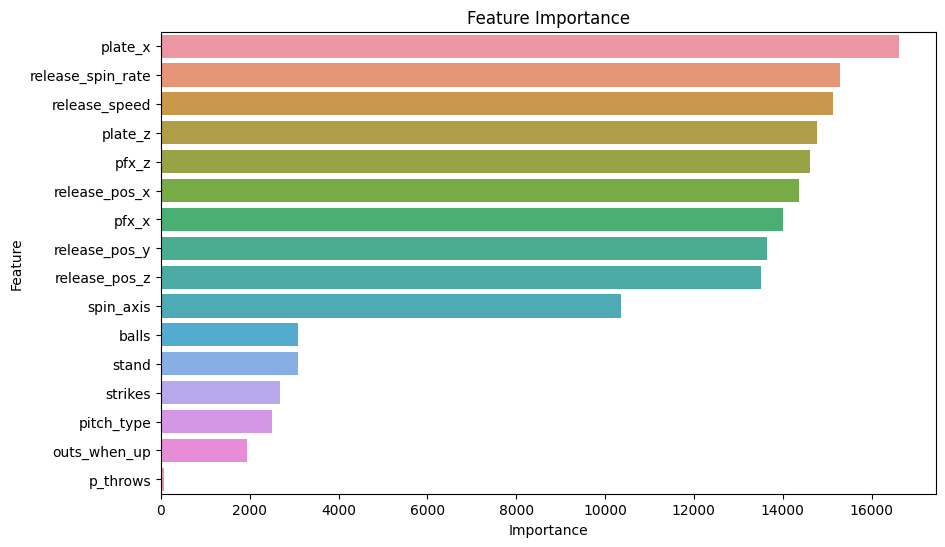

In [123]:
sorted_feature_importance = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    y='Feature',
    x='Importance',
    data=sorted_feature_importance
)
plt.title('Feature Importance')
plt.show()

In [124]:
y_preds = runExpectancyModel.predict(X_test)
y_preds = pd.DataFrame(y_preds)

predictionEvaluation(y_preds)

Mean: -1.0491973625903483e-05
Median: -0.0076643554493784904
SD: 0.04735693335533142
Min: -0.3115573823451996
Max: 0.9179966449737549


In [125]:
# Getting data to make STERA with
runExpectancy1 = strike_after.copy()
runExpectancy1 = runExpectancy1[['balls', 'strikes', 'outs_when_up', 'on_1b', 'on_2b', 'on_3b', 'plate_x', 'plate_z', 'pfx_x', 'pfx_z', 'release_speed', 'release_spin_rate', 'spin_axis', 'release_extension', 'release_pos_y', 'release_pos_x', 'release_pos_z', 'delta_run_exp']]
runExpectancy1 = runExpectancy1.dropna()

In [126]:
X_train, X_test, y_train, y_test = train_test_split(takenPitches_train_noK, takenPitches_label, test_size = 0.1)

In [127]:
runExpectancy1.head()

,balls,strikes,outs_when_up,on_1b,on_2b,on_3b,plate_x,plate_z,pfx_x,pfx_z,release_speed,release_spin_rate,spin_axis,release_extension,release_pos_y,release_pos_x,release_pos_z,delta_run_exp
0,0,0,0,0,0,0,-0.23,2.17,0.68,1.55,95.2,2555.0,144.0,6.6,53.86,2.19,6.19,-0.042
1,0,1,0,0,0,0,-1.41,2.68,0.86,1.51,94.9,2540.0,148.0,6.5,54.00,1.96,6.32,0.032
2,1,1,0,0,0,0,-0.85,0.68,0.43,0.44,87.9,2413.0,139.0,6.6,53.94,2.25,6.10,-0.060
3,1,2,0,0,0,0,-0.92,-0.54,0.08,0.45,88.2,2356.0,132.0,6.3,54.18,2.44,5.96,0.035
4,2,2,0,0,0,0,-1.35,2.03,0.74,1.51,95.8,2599.0,149.0,6.6,53.91,1.93,6.23,0.104


In [128]:
runExpectancy1_train = runExpectancy1.iloc[:,:-1]
runExpectancy1_label = runExpectancy1['delta_run_exp']

In [129]:
# Predictions for STERA
y_preds_all = runExpectancyModel.predict(runExpectancy1_train)
y_preds_all = pd.DataFrame(y_preds_all)

In [130]:
# Combining data with predictions
pred_stera = pd.concat([mlbPBP.reset_index(drop=True), y_preds_all.reset_index(drop=True)], axis=1)
pred_stera = pred_stera.rename(columns={0:'PredRE'})
pred_stera = pred_stera[['player_name', 'game_year', 'PredRE']]

In [131]:
pred_stera.head(10)

,player_name,game_year,PredRE
0,"Hampson, Garrett",2020,-0.017960
1,"Hampson, Garrett",2020,0.033462
2,"Hampson, Garrett",2020,0.036515
3,"Hampson, Garrett",2020,0.029483
4,"Hampson, Garrett",2020,0.074118
5,"Hampson, Garrett",2020,-0.063329
6,"Hampson, Garrett",2020,0.302491
7,"Story, Trevor",2020,0.007498
8,"Story, Trevor",2020,0.072012
9,"Story, Trevor",2020,0.006630


In [132]:
# Creating STERA+
mean = np.mean(pred_stera['PredRE'])
std_dev = np.std(pred_stera['PredRE'])

# Standardize and rescale
pred_stera['PredRE_Std'] = (pred_stera['PredRE'] - mean) / std_dev
pred_stera['STERA+'] = 100 + 250 * pred_stera['PredRE_Std']

In [133]:
pred_stera.head(10)

,player_name,game_year,PredRE,PredRE_Std,STERA+
0,"Hampson, Garrett",2020,-0.017960,-0.368149,7.962868
1,"Hampson, Garrett",2020,0.033462,0.689478,272.369568
2,"Hampson, Garrett",2020,0.036515,0.752264,288.066071
3,"Hampson, Garrett",2020,0.029483,0.607639,251.909729
4,"Hampson, Garrett",2020,0.074118,1.525668,481.416901
5,"Hampson, Garrett",2020,-0.063329,-1.301271,-225.317871
6,"Hampson, Garrett",2020,0.302491,6.222724,1655.681152
7,"Story, Trevor",2020,0.007498,0.155452,138.862946
8,"Story, Trevor",2020,0.072012,1.482351,470.587708
9,"Story, Trevor",2020,0.006630,0.137600,134.399994


In [134]:
STERAPlusLeaderboard = pred_stera.groupby(['Name', 'Year'])['STERA+'].agg([np.mean, 'count']).sort_values('mean', ascending=False).reset_index()
STERAPlusLeaderboard = STERAPlusLeaderboard.rename(columns={'player_name':'Name', 'game_year':'Year', 'mean':'STERA+', 'count':'Count'})
STERAPlusLeaderboard[(STERAPlusLeaderboard['Count'] > 1000)].head(25)

KeyError: 'Name'

In [ ]:
STERAPlusLeaderboard = pred_stera.groupby(['Name', 'Year'])['STERA+'].agg([np.mean, 'count']).sort_values('mean', ascending=True).reset_index()
STERAPlusLeaderboard = STERAPlusLeaderboard.rename(columns={'player_name':'Name', 'game_year':'Year', 'mean':'STERA+', 'count':'Count'})
STERAPlusLeaderboard[(STERAPlusLeaderboard['Count'] > 1000)].head(25)